In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error



import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/air-quality-india.csv')

In [3]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


In [4]:
df.shape

(36192, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36192 entries, 0 to 36191
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  36192 non-null  object 
 1   Year       36192 non-null  int64  
 2   Month      36192 non-null  int64  
 3   Day        36192 non-null  int64  
 4   Hour       36192 non-null  int64  
 5   PM2.5      36192 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.7+ MB


# Prepare Data

In [7]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


In [8]:
df.drop(columns = ['Year', 'Month', 'Day', 'Hour'], inplace = True)

In [9]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [10]:
df.duplicated().sum()

0

In [11]:
df = df.set_index('Timestamp')

In [12]:
df.head()

,PM2.5
Timestamp,
2017-11-07 12:00:00,64.51
2017-11-07 13:00:00,69.95
2017-11-07 14:00:00,92.79
2017-11-07 15:00:00,109.66
2017-11-07 16:00:00,116.50


In [13]:
#Assume time is already in UTC
df.index = df.index.tz_localize('UTC').tz_convert('Asia/Kolkata')

In [14]:
df.index[:5]

DatetimeIndex(['2017-11-07 17:30:00+05:30', '2017-11-07 18:30:00+05:30',
               '2017-11-07 19:30:00+05:30', '2017-11-07 20:30:00+05:30',
               '2017-11-07 21:30:00+05:30'],
              dtype='datetime64[ns, Asia/Kolkata]', name='Timestamp', freq=None)

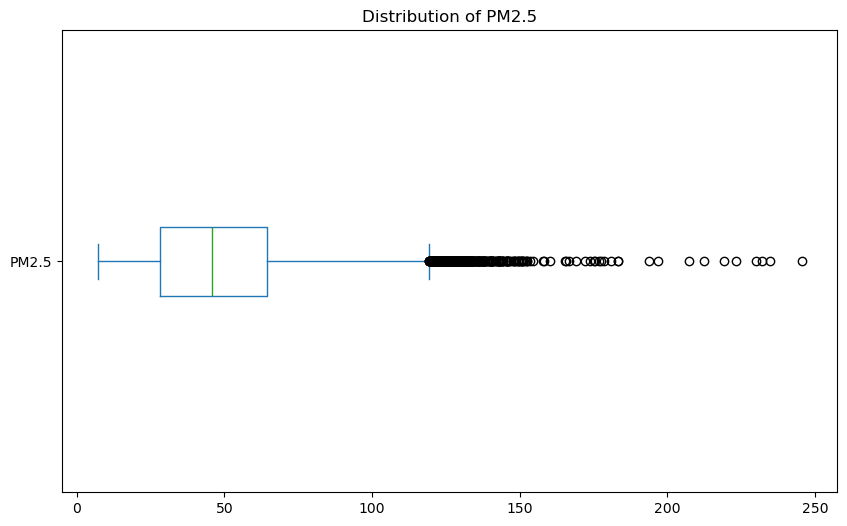

In [15]:
fig, ax = plt.subplots (figsize = (10, 6))
df['PM2.5'].plot(kind = 'box', vert = False, ax = ax , title = 'Distribution of PM2.5');

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PM2.5,36192.0,49.308429,24.863511,7.02,28.08,45.73,64.52,245.63


In [17]:
# observation - no outlier

In [18]:
# plot Timeseries

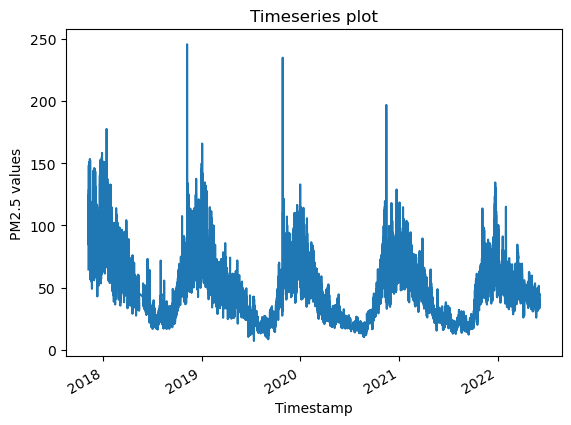

In [19]:
df['PM2.5'].plot(ylabel='PM2.5 values', title = 'Timeseries plot');

# observation
 - No missing values
 - It is non-stationary

# Resample Data

In [22]:
df['PM2.5'].resample('D').mean().to_frame().isna().sum()

PM2.5    54
dtype: int64

In [158]:
# Resample and remove NaN
df = df['PM2.5'].resample('D').mean().to_frame().fillna(method = 'ffill')

In [24]:
# validate if there are still NaN values
df.isna().sum()

PM2.5    0
dtype: int64

# Exploratory Data Analysis

# Rolling Window

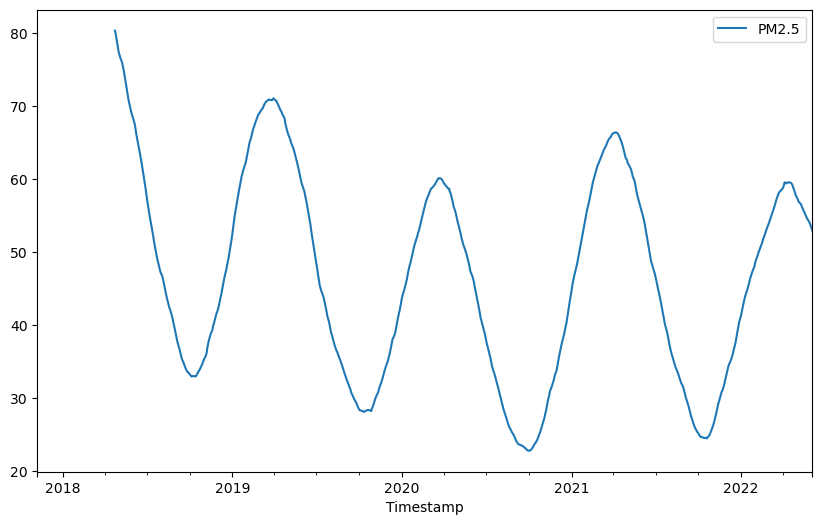

In [27]:
fig, ax = plt.subplots(figsize = (10, 6))
df.rolling(168).mean().plot(ax =ax, ylabel='', title = '');

# Create Lag(Predictor)

In [29]:
df['PMt-1'] = df['PM2.5'].shift(1)

In [30]:
df.dropna(inplace =True)

In [31]:
df.head()

,PM2.5,PMt-1
Timestamp,,
2017-11-08 00:00:00+05:30,105.876957,100.152857
2017-11-09 00:00:00+05:30,114.665000,105.876957
2017-11-10 00:00:00+05:30,118.872609,114.665000
2017-11-11 00:00:00+05:30,109.895000,118.872609
2017-11-12 00:00:00+05:30,117.071579,109.895000


# Autocorrelation

In [33]:
df.corr()

,PM2.5,PMt-1
PM2.5,1.000000,0.971555
PMt-1,0.971555,1.000000


<Axes: xlabel='PM2.5', ylabel='PMt-1'>

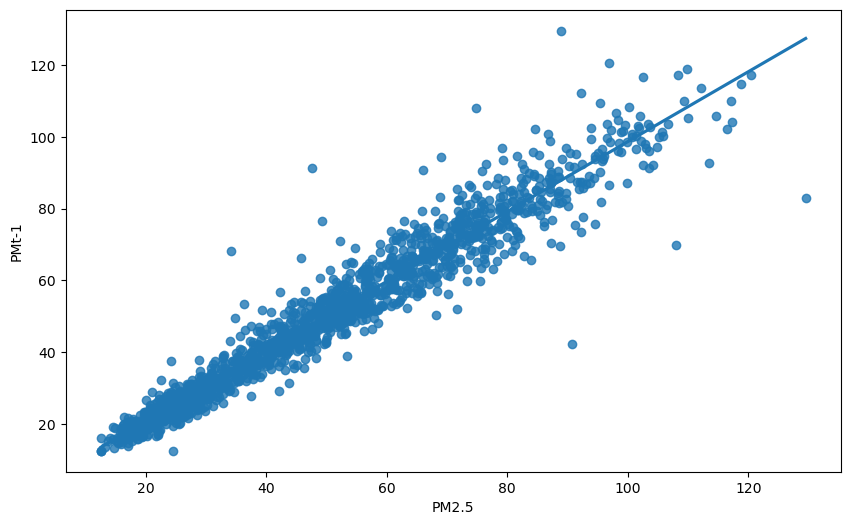

In [152]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x = df['PM2.5'], y =df['PMt-1'], ci = None, ax = ax)

Text(0.5, 1.0, 'Autcorrelation')

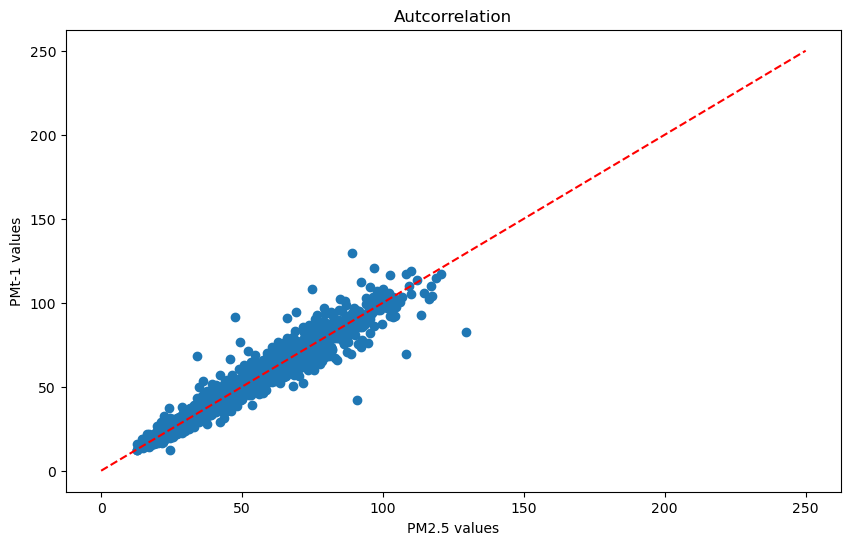

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df['PM2.5'], y =df['PMt-1'])
ax.plot([0,250], [0,250], color = 'red', linestyle = '--')
plt.xlabel('PM2.5 values')
plt.ylabel('PMt-1 values')
plt.title('Autcorrelation')

In [35]:
# split data into X matrix and y Vector

In [36]:
target = 'PM2.5'
X = df.drop(columns = target)
y = df[target]

In [37]:
# Train test split

In [38]:
cutoff = round(len(X) * 0.8)

In [39]:
X_train = X.iloc[:cutoff]
X_test = X.iloc[cutoff:]
y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]

In [40]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1336, 1)
(1336,)
(334, 1)
(334,)


# Build Baseline Model

In [42]:
y_mean = y_train.mean()
y_predict_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_predict_baseline)

print('mean P2 value is', round(y_mean, 3))
print('baseline mae is', round(mae_baseline, 3))

mean P2 value is 49.676
baseline mae is 20.538


In [43]:
# Iterate or Select Model

In [44]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [45]:
#  Evaluate

In [46]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))

In [47]:
test_mae = mean_absolute_error(y_test, model.predict(X_test))

In [48]:
print('training mae is', training_mae)
print('test mae is', test_mae)

training mae is 3.659404301667696
test mae is 3.149982768059814


# Communicate Result

In [50]:
intercept = round(model.intercept_, 2)

In [51]:
coefficient = model.coef_.round(2)

In [108]:
print(f'PM2.5 = {intercept} + {coefficient[0]} * PMt-1')

PM2.5 = 1.38 + 0.97 * PMt-1


In [53]:
#  put into DataFrame

In [54]:
df_pred_test = pd.DataFrame(
    {
    'y_test': y_test,
    'y_pred': model.predict(X_test)
    }
)

In [55]:
df_pred_test

,y_test,y_pred
Timestamp,,
2021-07-06 00:00:00+05:30,29.241667,29.007102
2021-07-07 00:00:00+05:30,30.513750,29.777604
2021-07-08 00:00:00+05:30,25.427083,31.013080
2021-07-09 00:00:00+05:30,24.082500,26.072798
2021-07-10 00:00:00+05:30,26.101667,24.766909
...,...,...
2022-05-31 00:00:00+05:30,39.869583,36.520312
2022-06-01 00:00:00+05:30,42.536667,40.099670
2022-06-02 00:00:00+05:30,41.136667,42.689999


In [56]:
# import warnings
# warnings.simplefilter(action ='ignore', category ='FutureWarnings')

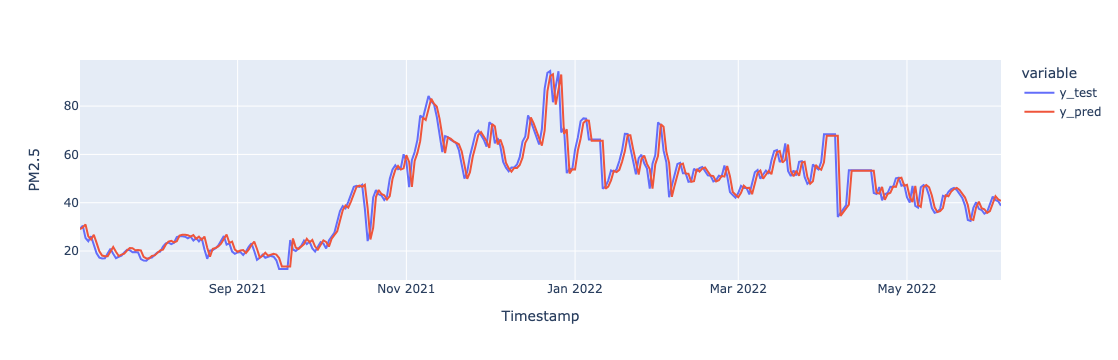

In [156]:
fig  = px.line(df_pred_test, labels = {'value':'PM2.5'})
fig.show()